In [8]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

In [9]:
OptInfo = {}
OptInfo['Bounds Longitude']     = [230,360]
OptInfo['Bounds Latitude']      = [-80,-40]
OptInfo['Grid Spacing (dx,dy)'] = [5,2.5]
OptInfo['Start Time']           = '2017-05-01'
OptInfo['End Time']             = '2017-06-01'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoint_LongPaths.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = None

In [10]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(OptInfo)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(0)

TT = TravelTime(cellGrid)
TT.Dijkstra(verbrose=True)

=== Processing Waypoint = LongPathStart ===
=== Processing Waypoint = LongPathEnd ===


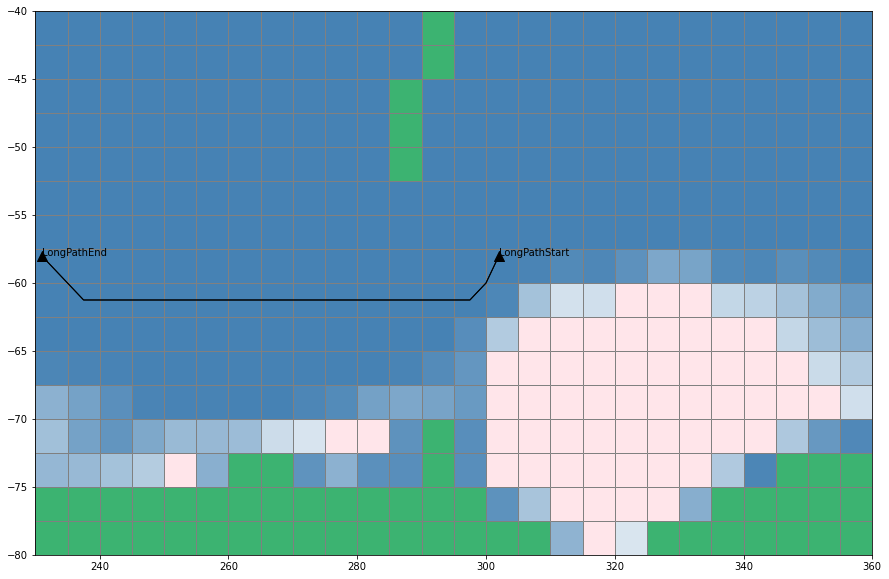

In [11]:
ax = TT.PlotPaths()

In [12]:
TT.PathSmoothing(maxiter=10)

 PATH: LongPathStart -> LongPathEnd 
 PATH: LongPathEnd -> LongPathStart 


(-70.0, -55.0)

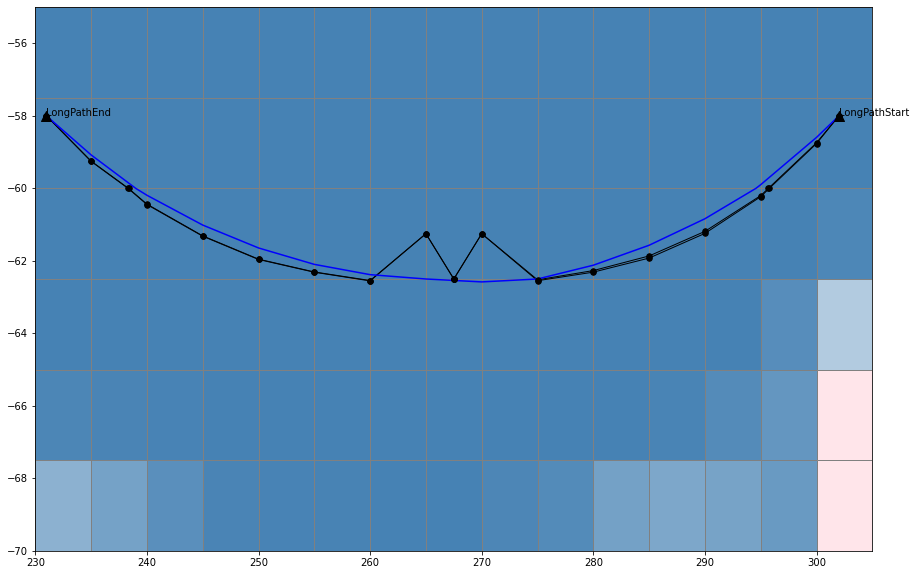

In [13]:
ax = TT.PlotPaths(routepoints=True)

GT = pd.read_csv('../../resources/GroundTruth_LongPath_End2Start_Smooth.csv')
GT['Long'] = GT['Long'] + 360
ax.plot(GT['Long'],GT['Lat'],'b')

ax.set_xlim([230,305])
ax.set_ylim([-70,-55])

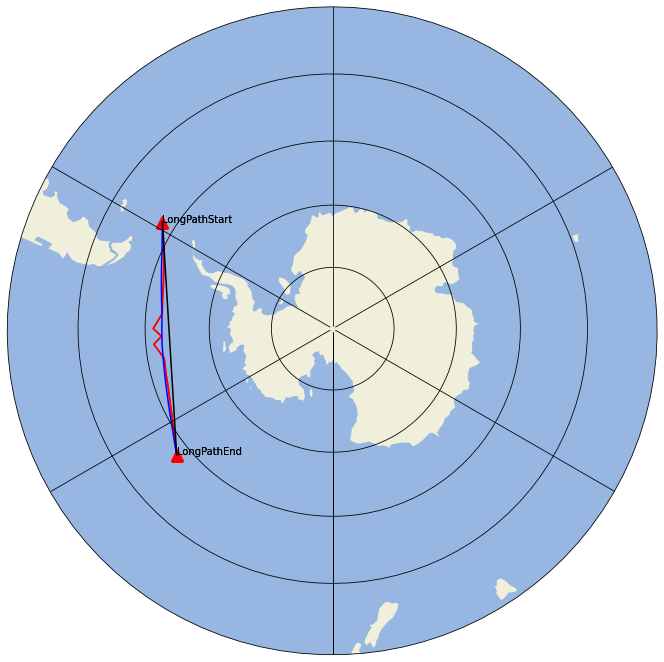

In [7]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature

PATH1 =  TT.Paths[0]['Path']['FullPath']

fig = plt.figure(figsize=[10, 10])
ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.gridlines(color='k')


for ii in range(len(TT.Paths)):
    PATH1 =  TT.Paths[ii]['Path']['FullPath']

    ax1.plot(PATH1[:,0]-360,PATH1[:,1],'r',transform=ccrs.PlateCarree())
    for ii, wpt in OptInfo['WayPoints'].iterrows():
        ax1.scatter(wpt['Long']-360,wpt['Lat'],150,marker='^',color='r',transform=ccrs.PlateCarree())
        ax1.text(wpt['Long']-360,wpt['Lat'],wpt['Name'],transform=ccrs.PlateCarree())


GT = pd.read_csv('../../resources/GroundTruth_LongPath_End2Start_Smooth.csv')
ax1.plot(GT['Long'],GT['Lat'],'b',transform=ccrs.PlateCarree())

ax1.plot([GT['Long'].iloc[0],GT['Long'].iloc[-1]],[GT['Lat'].iloc[0],GT['Lat'].iloc[-1]],'k',transform=ccrs.Geodetic())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)



plt.show()